In [1]:
# Vikram & Sahana
# Jan 15 2022
# Classical Machine Learning Model V2
# Detecting Severity of Alzheimer's with brain scans more accurately

In [1]:
# This has all of the imports, meaning if you dont have something, it will tell you in this kernel
from tqdm import tqdm
import os
import cv2
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
import tflearn
import nibabel as nib
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.data_utils import to_categorical, image_preloader
from tflearn.metrics import Accuracy
import numpy as np
import pandas as pd
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc
import numpy as np
from glob import glob
from skimage.io import imread
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
import numpy as np
import argparse
import locale
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
IMAGE_DIR = "/Users/sidharthanantha/Documents/SciFair 2022/Alzheimers_Dataset_V3"
CSV_DIR = "/Users/sidharthanantha/Documents/SciFair 2022/classical_v2_attr_data.csv"
IMG_SHAPE = (70, 70)
LR = 1e-3
MODEL_NAME = "classifying_alzheimers_v2.model"
Y_ATTR = "Research Group"
DATA_NUMBERS = ['Weight','APOE A1','APOE A2','Age','MMSE Total Score','GDSCALE Total Score','Global CDR','FAQ Total Score','NPI-Q Total Score']
DATA_CATEGORIES = ['Sex', 'Description','Type','Imaging Protocol','Structure']
NUM_CLASSES = 2
EPOCHS = 200

In [4]:
TEST_COLS = [
    "Boogie", # Boogie is there to mean "dont remove any columns" because Boogie is not a column
    'GDSCALE Total Score', 
    'NPI-Q Total Score', 
    'Sex', 
    'Weight',
] # Each array element represents which column you want to test
  # adding an array element will remove that column from the array and test it

TEST_ROWS = [
    ['Boogie', 'Woogie'],
    ['Imaging Protocol', 'Field Strength=1.5'],
    ['Imaging Protocol', 'Field Strength=3.0'],
    ['Imaging Protocol', 'Acquisition Type=2D'],
    ['Imaging Protocol', 'Acquisition Type=3D'],
    ['Imaging Protocol', 'Weighting=PD'],
    ['Imaging Protocol', 'Weighting=T1'],
    ['Imaging Protocol', 'Weighting=T2'],
    
] # Each array element represents the col and value you want to test
  # Adding an array element will filter the df so only that value will be in the column
  # The elements are in the format [column, value]

# After running all of the Kernels, once you change these arrays, run kernels 12 and 14 again

In [5]:
def process_images():
    print("Processing Images...")
    df = pd.read_csv(CSV_DIR) # reads in csv file
    df["Downloaded"] = "" # creates new Downloaded column
    
    
    for index, row in df.iterrows(): # goes through every row
        
        # CONNECTING EACH IMAGE TO ROW IN THE 
        id = row['Image ID']
        for i in range(len(images_set)): # checks through all the images
            if "I%s" % id in image_info[i][0]: # if the image id is in the file name of the image being checked
                df.at[index,'Downloaded'] = i # store the index
                image_info[i][1] = True
        
        # CHANGING RESEARCH GROUP TO A NUMBER
        if (row['Research Group'] == "AD"): df.at[index,'Research Group'] = 1
        elif (row['Research Group'] == "CN"): df.at[index,'Research Group'] = 0
        else: 
            df.at[index,'Research Group'] = 2
            
        # CHANGING ANY COL,ROW WHERE IT SAYS NAN
        for col in df:
            if index > 0 and pd.isnull(row[col]):
                if row["Subject ID"] == df.at[index-1,"Subject ID"]:
                    df.at[index, col] = df.at[index-1,col]
        
    df.replace([np.inf, -np.inf], np.nan, inplace=True)   
    df.dropna(inplace=True) 
    
    
    df2 = df.loc[df['Downloaded'] != ""]
    df3 = df2.loc[df2['Research Group'] <= 1]
    print("Processed!")
    return df3

def process_lattributes(df, dat):
    all_data = []
    all_data_info = []
    for test_this in TEST_COLS:
        try_these_points = [[], []]
        for asdf in DATA_NUMBERS:
            if test_this != asdf: try_these_points[0].append(asdf)
        for asdf in DATA_CATEGORIES:
            if test_this != asdf: try_these_points[1].append(asdf)
        le_data = actual_process_lattributes(df, dat, cols=try_these_points)
        all_data.append(le_data)
        all_data_info.append("Remove Col: %s" % test_this)
        
    for colandval in TEST_ROWS:
        coltoremove = colandval[0]
        valtoremove = colandval[1]
        if (coltoremove in list(df)): df_test = df.loc[df[coltoremove].str.contains(valtoremove)]
        else: df_test = df.loc[df["Downloaded"] != "Boogie Woogie"]
        try_these_points = [[], []]
        for asdf in DATA_NUMBERS:
            if coltoremove != asdf: try_these_points[0].append(asdf)
        for asdf in DATA_CATEGORIES:
            if coltoremove != asdf: try_these_points[1].append(asdf)
        if (df_test.shape[0] == 0):
            print("Specifying %s down to %s doesn't work... Make sure you downloaded / are checking the right thing"
                 % (coltoremove, valtoremove))
            continue
        le_data = actual_process_lattributes(df_test, dat, cols=try_these_points)
        all_data.append(le_data)
        all_data_info.append("Filter from %s: %s" % (coltoremove, valtoremove))
        
    return all_data, all_data_info
    

def actual_process_lattributes(df, dat, cols=[DATA_NUMBERS, DATA_CATEGORIES]):

    print("Processing Scan Attributes...")
    cs = MinMaxScaler()
    
    continuous = cs.fit_transform(dat[cols[0]])
    categoricals = []
    for i in cols[1]:
        zipBinarizer = LabelBinarizer().fit(df[i])
        categorical = zipBinarizer.transform(dat[i])
        categoricals.append(categorical)
    
    x = np.hstack([continuous, *categoricals])
    print("Processed!")
    return x



def get_data():
    print("Getting Image Data...")
    path = IMAGE_DIR
    images = []
    image_info = []
    for fol1 in tqdm(os.listdir(path), disable=True):
        if fol1 == ".DS_Store": continue
        path1 = os.path.join(path, fol1)
        for fol2 in tqdm(os.listdir(path1), disable=True):
            if fol2 == ".DS_Store": continue
            path2 = os.path.join(path1, fol2)
            for fol3 in tqdm(os.listdir(path2), disable=True):
                if fol3 == ".DS_Store": continue
                path3 = os.path.join(path2, fol3)
                for fol4 in tqdm(os.listdir(path3), disable=True):
                    if fol4 == ".DS_Store": continue
                    path4 = os.path.join(path3, fol4)
                    # After going through all of the subfolders, we can finally see the image
                    for img in tqdm(os.listdir(path4), disable=True):
                        if img == ".DS_Store": continue
                        # print(img)
                        try:
                            path5 = os.path.join(path4, img)
                            image_data = nib.load(path5).get_fdata() # get the numbers of the 3D image
                            image_data = np.rot90(image_data) # make it axial
                            our_slice = image_data[image_data.shape[0]//2] # get the very middle slice
                            # print(type(our_slice))
                            # print(img)
                            our_slice_reshaped = scale_array(our_slice, IMG_SHAPE)
                            images.append(our_slice_reshaped) # add it to the list
                            image_info.append([img, False])
                        except:
                            pass
    print("Got!")
    return images, image_info

def scale_array(x, new_size):
    new_size = (new_size[0]/x.shape[0],new_size[1]/x.shape[1], 1)
    y = scipy.ndimage.zoom(x, new_size)
    return y

In [6]:
def create_mlp(dim, regress=False, verbose=True):
    if verbose: print("Creating MLP Classifier for attributes...")
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))
    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
    # return our model
    if verbose: print("Created!")
    return model

def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False, verbose=True):
    if verbose: print("Creating CNN for images...")
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    # define the model input
    inputs = Input(shape=inputShape)
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)
    # construct the CNN
    model = Model(inputs, x)
    # return the CNN
    if verbose: print("Created!")
    return model

In [7]:
def score(testX, testY, model,verbose=False):
    score = 0
    start = int(round(time()*1000))
    pred = model.predict(testX)
    end = int(round(time()*1000))
    for i in range(len(pred)):
        prediction = np.where(pred[i] == np.amax(pred[i]))[0][0]
        real = np.where(testY[i] == 1)[0][0]
        # print(pred[i], testY[i])
        if verbose: print("Predicted Class vs. Actual Class: %s %s" % (prediction, real))
        if (prediction == real):
            score+=1
        else: 
            if verbose: print("   Incorrect!")
    return score / len(pred), end-start

/Users/sidharthanantha/Documents/SciFair 2022/Alzheimers_Dataset_V3/014_S_1095/3-plane_localizer/2008-01-29_09_41_01.0/S45074/ADNI_014_S_1095_MR_3-plane_localizer__br_raw_20080130070103728_1_S45074_I88871.nii


/var/folders/f3/048ydxg12gv9kdbdkq4drhkc0000gn/T/ipykernel_19937/3644236801.py:32: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  image_data = nib.load(image).get_data()


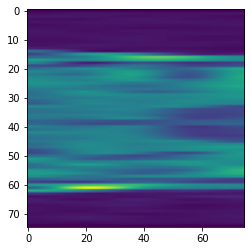

In [10]:
# OPTIONAL

def view_image():
    import numpy as np # linear algebra
    import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
    import skimage, os
    from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
    from skimage.measure import label,regionprops, perimeter
    from skimage.morphology import binary_dilation, binary_opening
    from skimage.filters import roberts, sobel
    from skimage import measure, feature
    from skimage.segmentation import clear_border
    from skimage import data
    from scipy import ndimage as ndi
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    import scipy.misc
    import numpy as np
    from glob import glob
    from skimage.io import imread
    BASE_IMG_PATH = "/Users/sidharthanantha/Documents/SciFair 2022/Alzheimers_Dataset_V3/014_S_1095/3-plane_localizer/2008-01-29_09_41_01.0/S45074/ADNI_014_S_1095_MR_3-plane_localizer__br_raw_20080130070103728_1_S45074_I88871.nii"

    image = glob(os.path.join(BASE_IMG_PATH, '*'))
    image = glob(BASE_IMG_PATH)[0]
    print(image)
    %matplotlib inline
    try:
        import nibabel as nib
    except:
        raise ImportError('bip bop')

    image_data = nib.load(image).get_data()
    image_data = np.rot90(image_data)
    # image_data = np.reshape(image_data, (44, 256, 256, 1))
    # image_data = np.rot90(image_data) # make it axial
    # print(image_data.shape)
    le_img = image_data[image_data.shape[0]//2]
    plt.imshow(le_img)
    # print(le_img[len(le_img)//2])
    # print(le_img.shape)
    le_img = scale_array(le_img, (75,75))
    plt.imshow(le_img)
    # print(image_data[2])
    # It's a little smushed but that's ok
view_image()

In [11]:
images_set, image_info = get_data()
print("There are %s images" % len(images_set))

Getting Image Data...
Got!
There are 11855 images


In [12]:
df = process_images()
print("DF's Shape: %s" % str(df.shape))
# df

Processing Images...
Processed!
DF's Shape: (2324, 22)


In [13]:
images_set
images = []

for index in list(df["Downloaded"]):
    images.append(images_set[index])
images = np.array(images)
print("Shape of the Image array: %s" % str(np.shape(images)))

Shape of the Image array: (2324, 70, 70, 1)


In [14]:
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

trainY = to_categorical(np.array(trainAttrX[Y_ATTR]))
testY = to_categorical(np.array(testAttrX[Y_ATTR]))
trainAttrX

trainNumXs, all_data_info = process_lattributes(df, trainAttrX)
testNumXs, all_data_info = process_lattributes(df, testAttrX)

Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan Attributes...
Processed!
Processing Scan 

In [15]:
def make_models(trainNums, verbose=True):
    mlp = create_mlp(trainNums.shape[1], regress=False, verbose=verbose)
    cnn = create_cnn(*np.shape(images[0]), regress=False, verbose=verbose)

    combinedInput = concatenate([mlp.output, cnn.output])

    x = Dense(4, activation="relu")(combinedInput)
    x = Dense(NUM_CLASSES, activation="softmax")(x)
    model = Model(inputs=[mlp.input, cnn.input], outputs=x)
    opt = Adam(learning_rate=1e-3, decay=1e-3 / 200)
    model.compile(loss="categorical_crossentropy", optimizer=opt)
    return model

def train(trainX, trainY, testX, testY, model, verbose=True):
    if verbose: print("Fitting...")
    start = int(round(time()*1000))
    model.fit(
        x=trainX, y=trainY,
        validation_data=(testX, testY),
        epochs=EPOCHS, batch_size=8, verbose=False)
    end = int(round(time()*1000))
    train_time = (end-start)/1000
    if verbose: print("Fitted!")
    return model, train_time

def test(testX, testY, model, extra={}):
    lescore, pred_time = score(testX, testY, model, verbose=False)

    print("After training the model with %s inputs and %s tests, here are the results"%(trainY.shape[0], testY.shape[0]))
    print("  While %s" % all_data_info[extra['i']])
    print("---")
    print("Time to train (%s inputs, epoch=%s) in sec: %s" % (trainY.shape[0], EPOCHS, extra['train_time']))
    print("Time to predict (%s values) in ms: %s" % (testY.shape[0], pred_time))
    print("Score: %s%%" % (lescore*100))
    print("==================\n")

    model.save(MODEL_NAME)

In [16]:
for i in range(len(trainNumXs)):
    model = make_models(trainNumXs[i], verbose=False)
    model, train_time = train([trainNumXs[i],trainImagesX], trainY, [testNumXs[i],testImagesX], testY, model, verbose=True)
    test([testNumXs[i],testImagesX], testY, model, extra={"train_time": train_time, "i": i})

Instructions for updating:
Colocations handled automatically by placer.
Fitting...


2022-01-18 23:14:45.502330: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Fitted!


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


After training the model with 1743 inputs and 581 tests, here are the results
  While Remove Col: Boogie
---
Time to train (1743 inputs, epoch=200) in sec: 2008.956
Time to predict (581 values) in ms: 845
Score: 97.93459552495698%

Fitting...
Fitted!
After training the model with 1743 inputs and 581 tests, here are the results
  While Remove Col: GDSCALE Total Score
---
Time to train (1743 inputs, epoch=200) in sec: 2008.822
Time to predict (581 values) in ms: 1114
Score: 97.59036144578313%

Fitting...
Fitted!
After training the model with 1743 inputs and 581 tests, here are the results
  While Remove Col: NPI-Q Total Score
---
Time to train (1743 inputs, epoch=200) in sec: 2044.842
Time to predict (581 values) in ms: 899
Score: 98.10671256454388%

Fitting...
Fitted!
After training the model with 1743 inputs and 581 tests, here are the results
  While Remove Col: Sex
---
Time to train (1743 inputs, epoch=200) in sec: 2049.477
Time to predict (581 values) in ms: 988
Score: 96.9018932874